In [1]:
import argparse
import ctypes
import json
import multiprocessing
import os
from typing import Dict

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from bcc import BPF
from adaptiveness import Adaptiveness, AdaptivenessType
from erase import MapType
from nprobe import Nprobe
from swap import TestType

plt.rcParams.update({'text.usetex' : True,
          'font.size': 14,
          "font.family": "sans-serif",
          "font.sans-serif": "Helvetica",
          'figure.figsize': (6.4,4)})

SIZE = 10**6
DURATION = 10 * SIZE
WIDTH=0.35


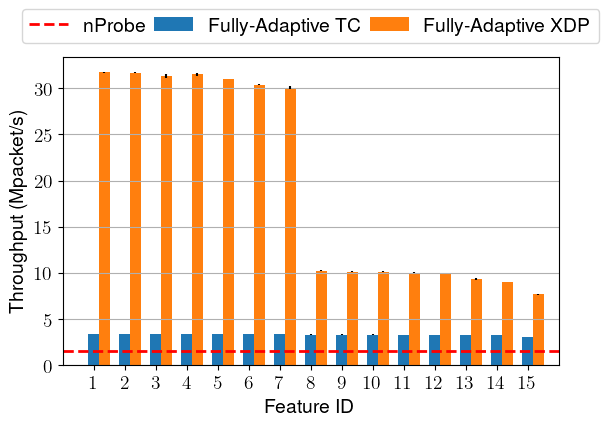

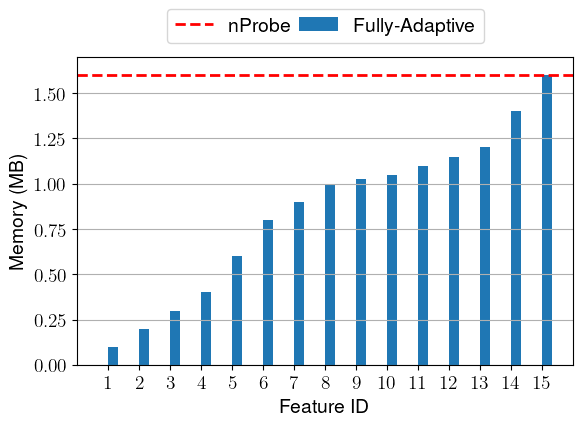

In [9]:
def plot_netflow_comp():
    with open(os.path.join("results", "nprobe", "results.json"), "r") as fp1:
        nprobe = json.load(fp1)

    real_nprobe = 1.5
    
    fig, ax = plt.subplots()
    ticks = list(range(1, 1 + len(Nprobe.NPROBE_FEATURES)))
    #ax.set_yscale("log")
    ax.hlines(xmin=min(ticks)-1, xmax=1+max(ticks), y= real_nprobe, label="nProbe", color="red", linestyles="dashed", linewidth=2)

    for mode, name, ss in [(BPF.SCHED_CLS, "TC", 0), (BPF.XDP, "XDP", WIDTH)]:
        vals = [np.array(x)/DURATION for x in nprobe[str(mode)].values()]
        ci = [1.96 * np.std(x)/(len(x)**(1/2)) for x in vals]
        vals = [np.mean(x) for x in vals]
        ax.bar([k + ss for k in ticks], vals, yerr=ci,
               label="Fully-Adaptive {}".format(name), width=WIDTH)
    ax.set_xlabel("Feature ID")
    ax.set_ylabel("Throughput (Mpacket/s)")
    
    ax.set_xticks(ticks)
    ax.set_xlim(right=max(ticks)+1, left=min(ticks)-1)
    ax.grid(axis="y")
    ax.legend(loc="center", bbox_to_anchor=(0.5, 1.1), ncols=3, labelspacing=0., columnspacing=.4)
    fig.savefig("compnprobe1.pdf", bbox_inches="tight")

    netflow_cost = 25000/10**6 * sum(ctypes.sizeof(v)
                                     for v in Nprobe.NPROBE_FEATURES.values())
    netflow_ad_cost = [25000/10**6*sum(ctypes.sizeof(v) for i, v in enumerate(
        Nprobe.NPROBE_FEATURES.values()) if i < ii) for ii in ticks]

    fig0, ax0 = plt.subplots()
    ax0.hlines(xmin=min(ticks)-1, xmax=1+max(ticks), y= netflow_cost, label="nProbe", color="red", linestyles="dashed", linewidth=2)
    ax0.bar([k + 0.15 for k in ticks], netflow_ad_cost, width=WIDTH, label="Fully-Adaptive")
    ax0.set_xticks(ticks)
    ax0.set_xlabel("Feature ID")
    ax0.set_ylabel('Memory (MB)')
    ax0.set_ylim(top=netflow_cost + 0.1)
    ax0.set_xlim(right=max(ticks)+1, left=min(ticks)-1)
    ax0.grid(axis="y")
    ax0.legend(loc="center", bbox_to_anchor=(0.5, 1.1), ncols=3, labelspacing=0., columnspacing=.4)
    fig0.savefig("compnprobe2.pdf", bbox_inches="tight")

plot_netflow_comp()

/tmp/ipykernel_350242/4142070047.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(erase[mt.value].keys()))


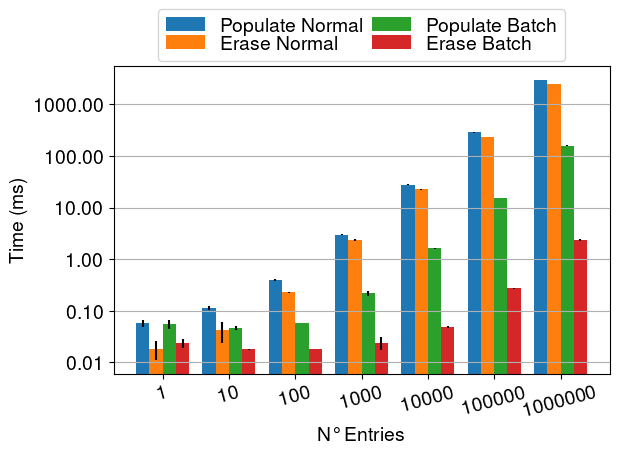

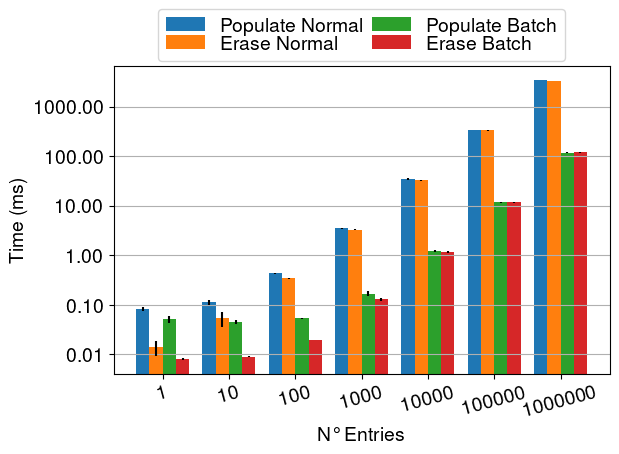

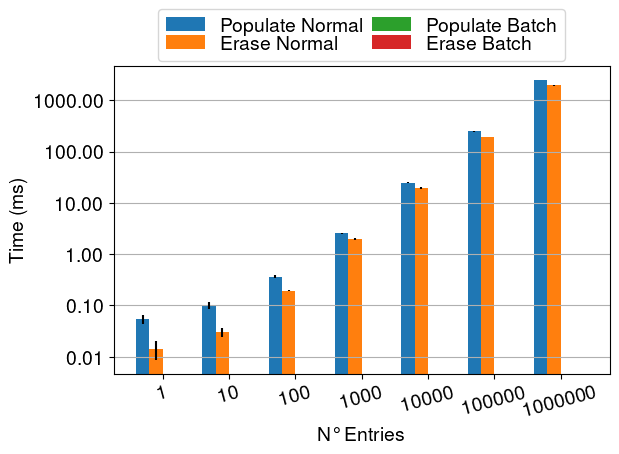

In [179]:
def plot_erase():
    with open(os.path.join("results", "erase", "results.json"), "r") as fp1:
        erase = json.load(fp1)

    ticks = list(range(len(erase[MapType.HASH.value])))
    for mt in MapType:
        fig, ax = plt.subplots()
        for i, name, ss in [(0, "Populate Normal", -0.3), (1, "Erase Normal", -0.1),
                            (2, "Populate Batch", +0.1), (3, "Erase Batch", +0.3)]:
            y = [[vv[i] for vv in v] for v in erase[mt.value].values()]
            y = [np.array(v)/10**6 for v in y]
            y_ci = [1.96 * np.std(k)/(len(k)**(1/2)) for k in y]
            y = [np.mean(k) for k in y]
            ax.bar([k+ss for k in ticks], y, yerr=y_ci, width=0.2, label=name)
            ax.set_xticklabels(list(erase[mt.value].keys()))

        ax.set_xticks(ticks)
        ax.tick_params(axis='x', rotation=15)
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.2f}'))
        ax.minorticks_off()
        ax.grid(axis="y")
        ax.legend(loc="center", bbox_to_anchor=(0.5, 1.1), ncols=2, labelspacing=0., columnspacing=.4)
        ax.set_xlabel('N° Entries')
        ax.set_ylabel('Time (ms)')
        fig.savefig(f"chart_erase{mt.value}.pdf", bbox_inches="tight")
    
plot_erase()

/tmp/ipykernel_19750/113779367.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


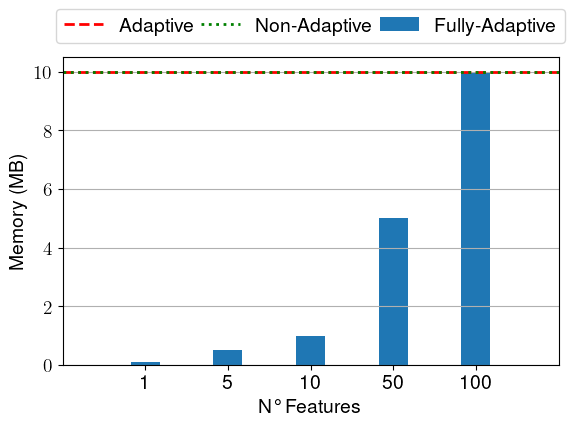

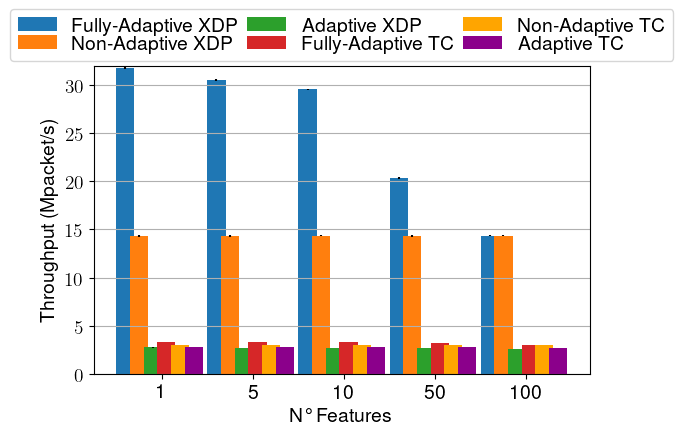

In [7]:
def plot_adaptiveness_comp():
    with open(os.path.join("results", "adaptiveness", "results.json"), "r") as fp1:
        adaptiveness = json.load(fp1)

    ticks = list(
        range(1, 1 + len(adaptiveness[str(BPF.XDP)][AdaptivenessType.FULLY.value])))

    non_ad_cost = 25000/10**6 * sum(ctypes.sizeof(v)
                                    for v in Adaptiveness.SUPPORTED_FEATURES.values())
    ad_cost = [25000/10**6*sum(ctypes.sizeof(v) for i, v in enumerate(Adaptiveness.SUPPORTED_FEATURES.values())
                               if i < int(ii)) for ii in adaptiveness[str(BPF.XDP)][AdaptivenessType.FULLY.value]]
    fig0, ax0 = plt.subplots()
    ax0.bar(ticks, ad_cost, width=WIDTH, label="Fully-Adaptive")
    ax0.hlines(xmin=min(ticks)-1, xmax=max(ticks)+1, y=non_ad_cost, linewidth=2, linestyles="dashed", label="Adaptive", color="red")
    ax0.hlines(xmin=min(ticks)-1, xmax=max(ticks)+1, y=non_ad_cost, linewidth=2, linestyles="dotted", label="Non-Adaptive", color="green")
    ax0.set_xticks(ticks)
    ax0.set_xticklabels(
        list(adaptiveness[str(BPF.XDP)][AdaptivenessType.FULLY.value].keys()))
    ax0.set_ylim(top=non_ad_cost+0.5)
    ax0.set_xlim(left=min(ticks)-1, right=max(ticks)+1)
    ax0.grid(axis="y")
    ax0.set_xlabel('N° Features')
    ax0.set_ylabel('Memory (MB)')
    ax0.legend(loc="center", bbox_to_anchor=(0.5, 1.1), ncols=3, labelspacing=0., columnspacing=.4)
    fig0.savefig("chartadaptivenessmemory.pdf", bbox_inches="tight")

    fig, ax = plt.subplots()
    ss = -0.4
    for mode, mname in [(BPF.XDP, "XDP"), (BPF.SCHED_CLS, "TC")]:
        for at, name in [(AdaptivenessType.FULLY.value, "Fully-Adaptive"),
                         ("NON", "Non-Adaptive"), (AdaptivenessType.TRADITIONAL.value, "Adaptive")]:
            fict = False
            if at == "NON":
                at = AdaptivenessType.FULLY.value
                fict = True
            vals = [
                np.array(x)/DURATION for x in adaptiveness[str(mode)][at].values()]
            ci = [1.96 * np.std(x)/(len(x)**(1/2)) for x in vals]
            vals = [np.mean(x) for x in vals]
            vals = vals if not fict else [vals[-1]]*len(vals)
            color = None
            if mode == BPF.SCHED_CLS and fict:
                color = "orange"
            elif mode == BPF.SCHED_CLS and at == AdaptivenessType.TRADITIONAL.value:
                color = "darkmagenta"
            ax.bar([k + ss for k in ticks], vals, yerr=ci,
                   label="{} {}".format(name, mname), width=0.2, color=color)
            ss += 0.15
    ax.set_xticklabels(
        list(adaptiveness[str(BPF.XDP)][AdaptivenessType.FULLY.value].keys()))
    ax.set_xticks(ticks)
    ax.set_ylim(top=32)
    ax.grid(axis="y")
    ax.set_xlabel('N° Features')
    ax.set_ylabel('Throughput (Mpacket/s)')
    ax.legend(loc="center", bbox_to_anchor=(0.5, 1.1), ncols=3, labelspacing=0., columnspacing=.4)
    fig.savefig("chartadaptivenesthroughput.pdf", bbox_inches="tight")

plot_adaptiveness_comp()

/tmp/ipykernel_19750/1657046520.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(compilation[tt].keys()))
/tmp/ipykernel_19750/1657046520.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(list(throughput[tt].keys()))


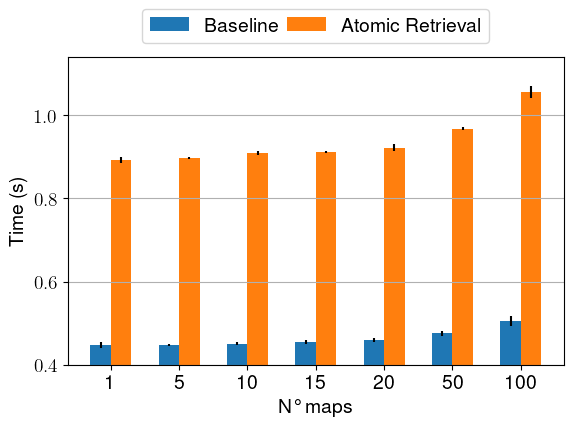

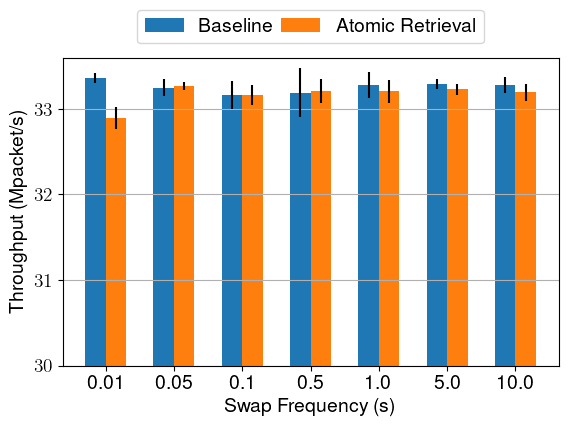

In [6]:
def plot_swap_overhead():
    with open(os.path.join("results", "swap", "results_compilation.json"), "r") as fp1, \
            open(os.path.join("results", "swap", "results_throughput.json"), "r") as fp2:
        compilation = json.load(fp1)
        throughput = json.load(fp2)

    ticks = list(
        range(1, len(compilation[TestType.COMPILATION_NORMAL.value])+1))

    fig, ax = plt.subplots()
    fig1, ax1 = plt.subplots()
    for i, (tt, name) in enumerate([(TestType.COMPILATION_NORMAL.value, "Baseline"),
                                    (TestType.COMPILATION_SWAP.value, "Atomic Retrieval")]):
        y = [np.array(v)/10**9 for v in compilation[tt].values()]
        y_ci = [1.96 * np.std(k)/(len(k)**(1/2)) for k in y]
        y = [np.mean(k) for k in y]
        ax.bar([(k - 0.15) if i == 0 else (k + 0.15)
               for k in ticks], y, yerr=y_ci, width=0.3, label=name)
        ax.set_xticklabels(list(compilation[tt].keys()))
    ax.set_xticks(ticks)
    ax.set_ylim(top=1.14, bottom=0.4)
    ax.grid(axis="y")
    ax.set_xlabel('N° maps')
    ax.set_ylabel('Time (s)')
    ax.legend(loc="center", bbox_to_anchor=(0.5, 1.1), ncols=3, labelspacing=0., columnspacing=.4)
    fig.savefig("chartswapcompilation.pdf", bbox_inches="tight")

    ticks = list(range(1, len(throughput[TestType.THROUGHPUT_NORMAL.value])+1))
    for i, (tt, name) in enumerate([(TestType.THROUGHPUT_NORMAL.value, "Baseline"),
                                    (TestType.THROUGHPUT_SWAP.value, "Atomic Retrieval")]):
        y = [np.array(v)/DURATION for v in throughput[tt].values()]
        y_ci = [1.96 * np.std(k)/(len(k)**(1/2)) for k in y]
        y = [np.mean(k) for k in y]
        ax1.bar([(k - 0.15) if i == 0 else (k + 0.15)
                for k in ticks], y, yerr=y_ci, width=0.3, label=name)
        ax1.set_xticklabels(list(throughput[tt].keys()))
    ax1.set_xticks(ticks)
    ax1.set_ylim(bottom=30, top=33.6)
    ax1.grid(axis="y")
    ax1.set_xlabel('Swap Frequency (s)')
    ax1.set_ylabel('Throughput (Mpacket/s)')
    ax1.legend(loc="center", bbox_to_anchor=(0.5, 1.1), ncols=3, labelspacing=0., columnspacing=.4)
    fig1.savefig("chartswapthroughput.pdf", bbox_inches="tight")

plot_swap_overhead()